## Import Packages

In [38]:
import os
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

data_dir = "../bda2024_mid_dataset"
%cd -q ../bda2024_mid_dataset

files = os.listdir(data_dir)
print("View all datasets:")
for f in files:
    print(f)

View all datasets:
bda2024_202203-202402_討論數據_dcard.csv
bda2024_202203-202402_內容數據_新聞3.csv
bda2024_微股力_籌碼數據-2年.csv
bda2024_202203-202402_內容數據_新聞2.csv
bda2024_微股力_社群PKTD-2年.csv
bda2024_202203-202402_內容數據_新聞1.csv
bda2024_202203-202402_討論數據_ptt.csv
bda2024_微股力_財報數據-2年.csv
bda2024_微股力_個股交易數據-2年.csv
bda2024_202203-202402_討論數據_mobile01-1.csv
bda2024_202203-202402_討論數據_mobile01-2.csv


## 資料前處理

In [2]:
def load_df(filepath, preview=True):
    print(f"\n----- Loading {filepath}... -----")
    df = pd.read_csv(filepath)
    print(f"Size of dataframe: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    if preview:
        print(df.head())
    return df

In [3]:
news1_df = load_df("bda2024_202203-202402_內容數據_新聞1.csv", preview=False)
news2_df = load_df("bda2024_202203-202402_內容數據_新聞2.csv", preview=False)
news3_df = load_df("bda2024_202203-202402_內容數據_新聞3.csv", preview=False)
news_df = pd.concat([news1_df, news2_df, news3_df], ignore_index=True)

disc_dcard_df = load_df("bda2024_202203-202402_討論數據_dcard.csv", preview=False)
disc_dcard_df.rename(columns={'forum': 'p_type'}, inplace=True)    # Repair column name typo in data
disc_m1_df = load_df("bda2024_202203-202402_討論數據_mobile01-1.csv", preview=False)
disc_m2_df = load_df("bda2024_202203-202402_討論數據_mobile01-2.csv", preview=False)
disc_ptt_df = load_df("bda2024_202203-202402_討論數據_ptt.csv", preview=False)
disc_df = pd.concat([disc_dcard_df, disc_m1_df, disc_m2_df, disc_ptt_df], ignore_index=True)

transaction_df = load_df("bda2024_微股力_個股交易數據-2年.csv")
report_df = load_df("bda2024_微股力_財報數據-2年.csv")
chip_df = load_df("bda2024_微股力_籌碼數據-2年.csv")
social_df = load_df("bda2024_微股力_社群PKTD-2年.csv")
transaction_df['stock_symbol'] = transaction_df['stock_symbol'].astype(str)
chip_df['stock_symbol'] = chip_df['stock_symbol'].astype(str)    # Repair mixed data types

print(f"\nnews_df\nSize of dataframe: {news_df.shape}\nColumns: {list(news_df.columns)}")
print(news_df.head())
print(f"\ndisc_df\nSize of dataframe: {disc_df.shape}\nColumns: {list(disc_df.columns)}")
print(disc_df.head())


----- Loading bda2024_202203-202402_內容數據_新聞1.csv... -----
Size of dataframe: (179449, 9)
Columns: ['id', 'p_type', 's_name', 's_area_name', 'post_time', 'title', 'author', 'content', 'page_url']

----- Loading bda2024_202203-202402_內容數據_新聞2.csv... -----
Size of dataframe: (15114, 9)
Columns: ['id', 'p_type', 's_name', 's_area_name', 'post_time', 'title', 'author', 'content', 'page_url']

----- Loading bda2024_202203-202402_內容數據_新聞3.csv... -----
Size of dataframe: (290929, 9)
Columns: ['id', 'p_type', 's_name', 's_area_name', 'post_time', 'title', 'author', 'content', 'page_url']

----- Loading bda2024_202203-202402_討論數據_dcard.csv... -----
Size of dataframe: (231320, 10)
Columns: ['id', 'forum', 's_name', 's_area_name', 'post_time', 'title', 'author', 'content', 'page_url', 'content_type']

----- Loading bda2024_202203-202402_討論數據_mobile01-1.csv... -----
Size of dataframe: (48725, 10)
Columns: ['id', 'p_type', 's_name', 's_area_name', 'post_time', 'title', 'author', 'content', 'page_ur

/var/folders/sr/p865qt7903n0vsc4f6bc11qr0000gn/T/ipykernel_23346/550884886.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Size of dataframe: (1154225, 8)
Columns: ['stock_name', 'stock_symbol', 'open', 'high', 'low', 'close', 'volume', 'date']
  stock_name stock_symbol   open   high    low  close  volume  \
0         日馳         1526  47.55  48.45  47.55  48.30     138   
1         日馳         1526  48.30  48.30  47.40  47.95     153   
2         日馳         1526  48.45  48.70  47.80  48.10     120   
3         日馳         1526  47.95  47.95  47.55  47.60     165   
4         日馳         1526  47.65  47.65  45.30  45.65     514   

                  date  
0  2022-03-01 00:00:00  
1  2022-03-02 00:00:00  
2  2022-03-03 00:00:00  
3  2022-03-04 00:00:00  
4  2022-03-07 00:00:00  

----- Loading bda2024_微股力_財報數據-2年.csv... -----
Size of dataframe: (16482, 16)
Columns: ['stock_name', 'stock_symbol', 'period', 'gross_profit_margin', 'operating_profit_margin', 'net_profit_margin', 'return_on_equity', 'debt_ratio', 'interest_coverage', 'current_ratio', 'quick_ratio', 'accounts_turnover', 'inventory_turnover', 'eps', 

/var/folders/sr/p865qt7903n0vsc4f6bc11qr0000gn/T/ipykernel_23346/550884886.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Size of dataframe: (998031, 9)
Columns: ['stock_name', 'stock_symbol', 'foreign_investor_bought', 'foreign_investor_sold', 'investment_trust_bought', 'investment_trust_sold', 'dealer_bought', 'dealer_sold', 'date']
  stock_name stock_symbol  foreign_investor_bought  foreign_investor_sold  \
0         信大         1109                     2000                   3000   
1         信大         1109                        0                  11000   
2         信大         1109                    11000                  21000   
3         信大         1109                    13000                   4000   
4         信大         1109                    68000                  17000   

   investment_trust_bought  investment_trust_sold  dealer_bought  dealer_sold  \
0                        0                      0           6000            0   
1                        0                      0           1000            0   
2                        0                      0              0            0  

## 1. 看漲文章、看跌文章
以 2023 年 1 月至 3 月、2023 年 4 月緯創和聯電的新聞分別做為訓練資料和測試資料。

### a. 處理股價資訊

1. 透過個股交易數據計算 label，處理資料時需注意股票開休市日期。\
舉例：[1, 2, 7, 9, 13, 14, 17]，Day 8 的新聞會用 Day 9 - 14 的漲跌資訊標記。

2. 需注意設定股價變化的 threshold，太高會使 y 中有許多數值為 0、太低則可能需要頻繁地交易，扣除手續費後便無利可圖。

In [4]:
stock_names = ["緯創", "聯電"]
dates_train = (datetime(2023, 1, 1).date(), datetime(2023, 3, 31).date())
dates_test = (datetime(2023, 4, 1).date(), datetime(2023, 4, 30).date())

In [29]:
%cd -q ../bda2024_mid_demo
transaction_df['date'] = pd.to_datetime(transaction_df['date']).dt.date
news_df['post_time'] = pd.to_datetime(news_df['post_time'])
news_df['post_time'] = news_df['post_time'].dt.date

def get_next_date(input_date, dates_list):
    index = sum(1 for d in dates_list if d < input_date)
    return index, dates_list[index]

def check_contained_option(title, options):
    for option in options:
        if option in title:
            return option
    return None

def print_logs(func):
    def wrapper(*args, **kwargs):
        print(f"Executing {func.__name__} ......")
        return func(*args, **kwargs)
    return wrapper

def load_news_embeddings():
    with open('embedding_dict_train.pkl', 'rb') as f:
        embedding_dict_train = pickle.load(f)
    with open('embedding_dict_test.pkl', 'rb') as f:
        embedding_dict_test = pickle.load(f)
    print(f"Size of <embedding_dict_train>: {len(embedding_dict_train)}")
    print(f"Size of <embedding_dict_test>: {len(embedding_dict_test)}")
    return embedding_dict_train, embedding_dict_test

class NewsPriceDataset:
    """
    Description
        Prepare training and testing dataset for stock trading.
        X: News embeddings, y: Change in stock price
    
    Strategies
        1. y discrete, news categorized as decrease (-1; sell), stable (0; hold), increase (+1; buy) sets.
        # 2. y continuous, trade if predicted price change is greater than given threshold.

    Parameters
        stock_names: Name of the stocks to trade.
        dates_train: (start_date, end_date), dates covered in the training set.
        dates_test:  (start_date, end_date), dates covered in the testing set.
        n_days_after, threshold: If the predicted price change in <n_days_after> days is greater than <threshold>, make a transaction.
    """
    def __init__(self, stock_names, dates_train, dates_test, n_days_after, threshold):
        self.stock_names = stock_names
        self.dates_train_start, self.dates_train_end = dates_train
        self.dates_test_start, self.dates_test_end = dates_test
        self.dates_list = sorted(transaction_df.loc[(transaction_df['stock_name']==self.stock_names[0])]['date'])

        self.n_days_after = n_days_after
        self.threshold = threshold
        self.answers = self.get_answers()
        self.news_by_date = {}

        self.embedding_dict = {}
        self.X_train, self.y_train = [], []
        self.X_test, self.y_test = [], []
    
    def __str__(self):
        return f"NewsPriceDataset for {self.stock_names} (n_days_after={self.n_days_after}, threshold={self.threshold})\n\
                 X_train: {np.shape(self.X_train)}, y_train: {np.shape(self.y_train)}\n\
                 X_test: {np.shape(self.X_test)}, y_test: {np.shape(self.y_test)}" 

    def get_answer(self, stock_name, input_date):
        i, _ = get_next_date(input_date, self.dates_list)
        open_date, close_date = self.dates_list[i], self.dates_list[i + self.n_days_after]
        
        open_price = transaction_df.loc[(transaction_df['date']==open_date) &
                                        (transaction_df['stock_name']==stock_name)]['open'].iloc[0]
        close_price = transaction_df.loc[(transaction_df['date']==close_date) & 
                                        (transaction_df['stock_name']==stock_name)]['close'].iloc[0]
        price_change = (close_price - open_price) / open_price
        print(f"{stock_name:5} | {price_change:5.2f} (Open: {open_date}, {open_price} | Close: {close_date}, {close_price})")

        if price_change >= self.threshold:
            return 1     # buy
        elif price_change <= -self.threshold:
            return -1    # sell
        else:
            return 0     # hold
    
    @print_logs
    def get_answers(self):
        if os.path.exists("answers.pkl"):
            with open('answers.pkl', 'rb') as f:
                answers = pickle.load(f)
        else:
            answers = {}
            final_day = self.dates_test_end + timedelta(days=30)
            dates_used = [date for date in self.dates_list if self.dates_train_start <= date <= final_day]
            for d in dates_used:
                for n in self.stock_names:
                    answers[(n, d)] = self.get_answer(n, d)
            with open('answers.pkl', 'wb') as f:
                pickle.dump(answers, f)
        return answers
    
    def export_news_csv(self):
        news_df['stock_name'] = news_df['title'].apply(check_contained_option, options=self.stock_names)

        news_df_train = news_df[(news_df['post_time'] >= self.dates_train_start) &
                                (news_df['post_time'] <= self.dates_train_end) &
                                (news_df['stock_name'].notna())]
        news_df_test = news_df[(news_df['post_time'] >= self.dates_test_start) &
                               (news_df['post_time'] <= self.dates_test_end) &
                               (news_df['stock_name'].notna())]
        print(f"Size of <news_df_train>: {news_df_train.shape}")
        print(f"Size of <news_df_test>: {news_df_test.shape}")
        news_df_train.to_csv("news_training.csv", index=False)
        news_df_test.to_csv("news_testing.csv", index=False)
    
    def prepare_dataset(self, embedding_dict):
        X = np.atleast_2d(list(embedding_dict.values()))
        y = []
        for key in tqdm(embedding_dict):
            input_date = next(iter(news_df.loc[news_df['id']==key, 'post_time']))
            stock_name = next(iter(news_df.loc[news_df['id']==key, 'stock_name']))
            _, next_date = get_next_date(input_date, self.dates_list)
            y.append(self.answers[(stock_name, next_date)])
        y = np.array(y)
        return X, y

    def prepare_main(self):
        embedding_dict_train, embedding_dict_test = load_news_embeddings()
        self.X_train, self.y_train = self.prepare_dataset(embedding_dict_train)
        self.X_test, self.y_test = self.prepare_dataset(embedding_dict_test)

        self.embedding_dict = {**embedding_dict_train, **embedding_dict_test}
        self.update_news_by_date(self.embedding_dict)
    
    @print_logs
    def update_news_by_date(self, embedding_dict):
        for key in tqdm(embedding_dict):
            input_date = next(iter(news_df.loc[news_df['id']==key, 'post_time']))
            if input_date in self.news_by_date:
                self.news_by_date[input_date].append(key)
            else:
                self.news_by_date[input_date] = [key]
        return self.news_by_date
    
    def get_test_batch(self, stock_name, input_date, n_days=2):
        """
            Predict the price change with news in the timespan (input_date - n_days, input_date)
        """
        i, _ = get_next_date(input_date, self.dates_list)
        news_id_list = []
        for k in range(n_days + 1):
            for news_id in self.news_by_date[self.dates_list[i - k]]:                               # given date range
                if next(iter(news_df.loc[news_df['id']==news_id, 'stock_name']))==stock_name:       # given stock
                    news_id_list.append(news_id)
        
        if len(news_id_list)==0:
            return None
        else:
            sub_dict = {key: self.embedding_dict[key] for key in news_id_list if key in self.embedding_dict}
            return self.prepare_dataset(sub_dict)
    
    def backtest(self, model):
        """
            For data in the test date range, predict the price change with the given model.
        """
        i, _ = get_next_date(self.dates_test_start, self.dates_list)
        z_test, z_test_pred = [], []
        while self.dates_list[i] <= self.dates_test_end:
            d = self.dates_list[i]
            for n in self.stock_names:
                if self.get_test_batch(n, d) is None:
                    continue
                else:
                    X_test, y_test = self.get_test_batch(n, d)
                    y_test_pred = model.predict(X_test)
                    price_change_pred = 1 if sum(y_test_pred) > 0 else 0 if sum(y_test_pred) == 0 else -1
                    price_change_true = self.answers[(n, d)]
                    
                    z_test.append(price_change_true)
                    z_test_pred.append(price_change_pred)
                    print(f"{d}, {n:5} | Ground Truth: {price_change_true}, Prediction: {price_change_pred}")
            i += 1
        return z_test, z_test_pred

### b. 準備訓練及測試資料
X: 新聞, y: 股價變化（-1: 下跌, 0: 持平, 1: 上漲）

In [30]:
dataset = NewsPriceDataset(stock_names, dates_train, dates_test, 5, 0.03)
dataset.export_news_csv()

Executing get_answers ......
緯創    |  0.03 (Open: 2023-01-03, 29.3 | Close: 2023-01-10, 30.15)
聯電    |  0.11 (Open: 2023-01-03, 40.45 | Close: 2023-01-10, 45.0)
緯創    |  0.04 (Open: 2023-01-04, 29.2 | Close: 2023-01-11, 30.3)
聯電    |  0.09 (Open: 2023-01-04, 41.25 | Close: 2023-01-11, 45.15)
緯創    |  0.02 (Open: 2023-01-05, 29.45 | Close: 2023-01-12, 30.1)
聯電    |  0.08 (Open: 2023-01-05, 41.8 | Close: 2023-01-12, 45.15)
緯創    |  0.02 (Open: 2023-01-06, 29.5 | Close: 2023-01-13, 30.2)
聯電    |  0.10 (Open: 2023-01-06, 41.3 | Close: 2023-01-13, 45.4)
緯創    |  0.01 (Open: 2023-01-09, 29.7 | Close: 2023-01-16, 30.1)
聯電    |  0.03 (Open: 2023-01-09, 43.6 | Close: 2023-01-16, 44.9)
緯創    |  0.00 (Open: 2023-01-10, 30.15 | Close: 2023-01-17, 30.2)
聯電    |  0.03 (Open: 2023-01-10, 44.5 | Close: 2023-01-17, 45.95)
緯創    |  0.03 (Open: 2023-01-11, 30.15 | Close: 2023-01-30, 31.2)
聯電    |  0.08 (Open: 2023-01-11, 45.3 | Close: 2023-01-30, 48.8)
緯創    |  0.04 (Open: 2023-01-12, 30.3 | Close: 2023-

在 [Google Colab](https://colab.research.google.com/drive/1dFeoGUoa0xgbRA7TsLwkg54tYguhlN4k?usp=sharing) 上使用現有的預訓練模型進行 inference，取得新聞標題的 embedding。（這裡以 `bert-base-chinese` 為例）

In [31]:
dataset.prepare_main()
print(dataset)

Size of <embedding_dict_train>: 313
Size of <embedding_dict_test>: 134


100%|██████████| 134/134 [00:06<00:00, 19.36it/s]


Executing update_news_by_date ......


100%|██████████| 447/447 [00:12<00:00, 36.66it/s]

NewsPriceDataset for ['緯創', '聯電'] (n_days_after=5, threshold=0.03)
                 X_train: (313, 768), y_train: (313,)
                 X_test: (134, 768), y_test: (134,)


In [32]:
X_train, y_train = dataset.X_train, dataset.y_train
X_test, y_test = dataset.X_test, dataset.y_test

counts = Counter(y_test)
for value, count in counts.items():
    print(f"{str(value).rjust(3)}: {count}")

  0: 77
  1: 41
 -1: 16


### c. 訓練模型

In [40]:
model = MLPClassifier(hidden_layer_sizes=(180, 36), max_iter=300)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5373


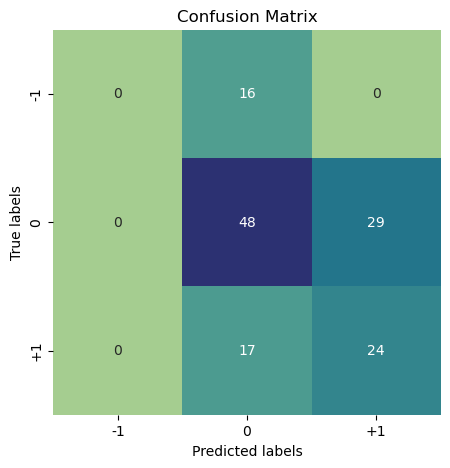

In [41]:
cm = confusion_matrix(y_test, y_test_pred)
class_labels = ['-1', '0', '+1']

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap="crest", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

### d. 預測：根據模型的預測結果決定是否買進或賣出。

In [27]:
z_test, z_test_pred = dataset.backtest(model)

100%|██████████| 7/7 [00:00<00:00, 19.23it/s]


2023-04-06, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 15/15 [00:01<00:00, 13.63it/s]


2023-04-06, 聯電    | Ground Truth: 0, Prediction: 0


100%|██████████| 11/11 [00:00<00:00, 19.21it/s]


2023-04-07, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 17/17 [00:00<00:00, 19.27it/s]


2023-04-07, 聯電    | Ground Truth: 0, Prediction: 0


100%|██████████| 10/10 [00:00<00:00, 19.21it/s]


2023-04-10, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 21/21 [00:01<00:00, 19.38it/s]


2023-04-10, 聯電    | Ground Truth: 0, Prediction: 1


100%|██████████| 10/10 [00:00<00:00, 19.33it/s]


2023-04-11, 緯創    | Ground Truth: 0, Prediction: 1


100%|██████████| 21/21 [00:01<00:00, 19.36it/s]


2023-04-11, 聯電    | Ground Truth: 0, Prediction: 1


100%|██████████| 11/11 [00:00<00:00, 19.33it/s]


2023-04-12, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 23/23 [00:01<00:00, 19.14it/s]


2023-04-12, 聯電    | Ground Truth: 0, Prediction: 1


100%|██████████| 9/9 [00:00<00:00, 18.51it/s]


2023-04-13, 緯創    | Ground Truth: 0, Prediction: 1


100%|██████████| 20/20 [00:01<00:00, 19.37it/s]


2023-04-13, 聯電    | Ground Truth: 0, Prediction: 1


100%|██████████| 6/6 [00:00<00:00, 19.30it/s]


2023-04-14, 緯創    | Ground Truth: 0, Prediction: 1


100%|██████████| 14/14 [00:00<00:00, 19.34it/s]


2023-04-14, 聯電    | Ground Truth: -1, Prediction: 1


100%|██████████| 3/3 [00:00<00:00, 19.35it/s]


2023-04-17, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 12/12 [00:00<00:00, 19.28it/s]


2023-04-17, 聯電    | Ground Truth: -1, Prediction: 1


100%|██████████| 5/5 [00:00<00:00, 19.36it/s]


2023-04-18, 緯創    | Ground Truth: 0, Prediction: 1


100%|██████████| 8/8 [00:00<00:00, 13.08it/s]


2023-04-18, 聯電    | Ground Truth: -1, Prediction: 1


100%|██████████| 7/7 [00:00<00:00, 19.33it/s]


2023-04-19, 緯創    | Ground Truth: 0, Prediction: 1


100%|██████████| 7/7 [00:00<00:00, 19.32it/s]


2023-04-19, 聯電    | Ground Truth: -1, Prediction: 1


100%|██████████| 11/11 [00:00<00:00, 19.35it/s]


2023-04-20, 緯創    | Ground Truth: 0, Prediction: 1


100%|██████████| 7/7 [00:00<00:00, 19.25it/s]


2023-04-20, 聯電    | Ground Truth: -1, Prediction: 1


100%|██████████| 15/15 [00:00<00:00, 19.33it/s]


2023-04-21, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 10/10 [00:00<00:00, 19.30it/s]


2023-04-21, 聯電    | Ground Truth: -1, Prediction: 1


100%|██████████| 15/15 [00:00<00:00, 19.36it/s]


2023-04-24, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 10/10 [00:00<00:00, 19.32it/s]


2023-04-24, 聯電    | Ground Truth: 0, Prediction: 1


100%|██████████| 14/14 [00:00<00:00, 19.07it/s]


2023-04-25, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 12/12 [00:00<00:00, 18.57it/s]


2023-04-25, 聯電    | Ground Truth: 0, Prediction: 0


100%|██████████| 10/10 [00:00<00:00, 13.11it/s]


2023-04-26, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 21/21 [00:01<00:00, 19.31it/s]


2023-04-26, 聯電    | Ground Truth: 1, Prediction: 1


100%|██████████| 9/9 [00:00<00:00, 19.30it/s]


2023-04-27, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 26/26 [00:01<00:00, 19.45it/s]


2023-04-27, 聯電    | Ground Truth: 0, Prediction: 1


100%|██████████| 8/8 [00:00<00:00, 19.31it/s]


2023-04-28, 緯創    | Ground Truth: 1, Prediction: 1


100%|██████████| 31/31 [00:01<00:00, 19.32it/s]

2023-04-28, 聯電    | Ground Truth: 0, Prediction: 1


Balanced accuracy: 0.3958


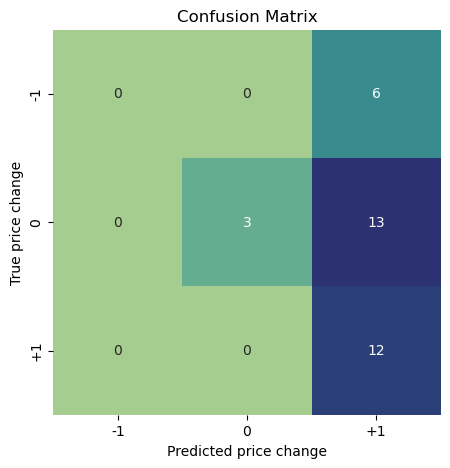

In [28]:
accuracy = balanced_accuracy_score(z_test, z_test_pred)
print(f"Balanced accuracy: {accuracy:.4f}")

cm = confusion_matrix(z_test, z_test_pred)
class_labels = ['-1', '0', '+1']

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap="crest", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted price change")
plt.ylabel("True price change")
plt.title("Confusion Matrix")
plt.show()

## 2. 其他參考方向

- 文章分類規則、同時使用新聞及社群討論資訊

- 以股價資訊、交易量、技術指標 (TA-Lib) 預測未來價格走勢

- 使用籌碼面資訊（e.g., 外資連買）、財報資訊（e.g., 長期而言，EPS 和股價呈正相關）進行綜合評估

## Playground

In [ ]:
print(list(transaction_df['stock_symbol'])[:100])

[1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526]


In [ ]:
print(list(disc_df.columns))
print('\n', disc_df["p_type"].value_counts())
print('\n', disc_df["s_name"].value_counts())
print('\n', disc_df["content_type"].value_counts())

['id', 'p_type', 's_name', 's_area_name', 'post_time', 'title', 'author', 'content', 'page_url', 'content_type']

 p_type
forum    437984
bbs       50805
Name: count, dtype: int64

 s_name
校園聊天-Dcard                     231320
Mobile01                       157939
Ptt                             50805
Mobile01 (收錄 2022/10/1 前資料)     48725
Name: count, dtype: int64

 content_type
reply      341834
r_reply     63681
main        32469
Name: count, dtype: int64


In [ ]:
print(disc_df.loc[disc_df['s_name']=="Ptt"].iloc[0])

id                                           1646066143199_PTT02R
p_type                                                        bbs
s_name                                                        Ptt
s_area_name                                                 Stock
post_time                                 2022-03-01 00:29:21.000
title                                     [新聞] 瑞士總統宣布「放棄中立」：加入制裁俄
author                                                     empliu
content         原文標題：\n\n快訊／瑞士總統宣布「放棄中立」：加入制裁俄羅斯　凍結普丁資產\n\n原文連...
page_url        http://www.ptt.cc/bbs/Stock/M.1646065764.A.E54...
content_type                                                  NaN
Name: 437984, dtype: object
